# Exploratory Data Cleaning - Griff

### In the cells below, IMDB, TMDB, and 'The Numbers' Datasets are imported into Pandas DataFrames for cleaning.  The following datasets are used:
- imdb name basics
- imdb title basics
- imdb title crew
- imdb title principals
- imdb title ratings
- tmdb movies
- tn movie budgets

#### Pandas and Numpy are used for cleaning and analysis.  Matplotlib is for visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### imdb.name.basics is imported and the birth_year, death_year, primary_profession, and known_for_titles columns are dropped because they will not be a part of this analysis.

In [5]:
imdb_name_basics = pd.read_csv('./data/imdb.name.basics.csv')
imdb_name_basics.drop(columns = {'birth_year', 
                                 'death_year',
                                 'primary_profession',
                                 'known_for_titles'},inplace=True)
imdb_name_basics.head()

,nconst,primary_name
0,nm0061671,Mary Ellen Bauder
1,nm0061865,Joseph Bauer
2,nm0062070,Bruce Baum
3,nm0062195,Axel Baumann
4,nm0062798,Pete Baxter


#### imdb.title.basics is imported and the columns original_title and start_year are dropped.  The variables we will potentially be examining are runtime_minutes and genres.  Rows with missing values for genres will be dropped because they can't be replaced.  Missing values for runtime_minutes will be replaced with the median value. Median = 87 minutes, Mean = 86 minutes.

,tconst,primary_title,runtime_minutes,genres
0,tt0063540,Sunghursh,175.0,"[Action, Crime, Drama]"
1,tt0066787,One Day Before the Rainy Season,114.0,"[Biography, Drama]"
2,tt0069049,The Other Side of the Wind,122.0,[Drama]
3,tt0069204,Sabse Bada Sukh,87.0,"[Comedy, Drama]"
4,tt0100275,The Wandering Soap Opera,80.0,"[Comedy, Drama, Fantasy]"


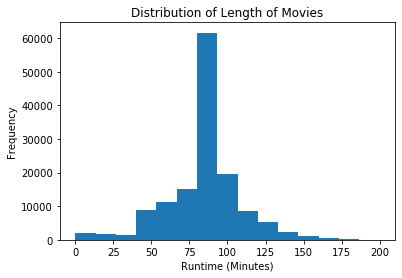

In [34]:
imdb_title_basics = pd.read_csv('./data/imdb.title.basics.csv')
imdb_title_basics.drop(columns = {'original_title','start_year'}, inplace = True)
imdb_title_basics = imdb_title_basics.loc[imdb_title_basics.genres.isna() == False]
imdb_title_basics.runtime_minutes.fillna(imdb_title_basics.runtime_minutes.median(), inplace = True)
imdb_title_basics.genres = imdb_title_basics.genres.apply(lambda x: x.split(','))
fig, ax = plt.subplots()
ax.set_xlabel('Runtime (Minutes)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Length of Movies')
ax.hist(imdb_title_basics.runtime_minutes, bins = 15, range = (0, 200));
imdb_title_basics.head()

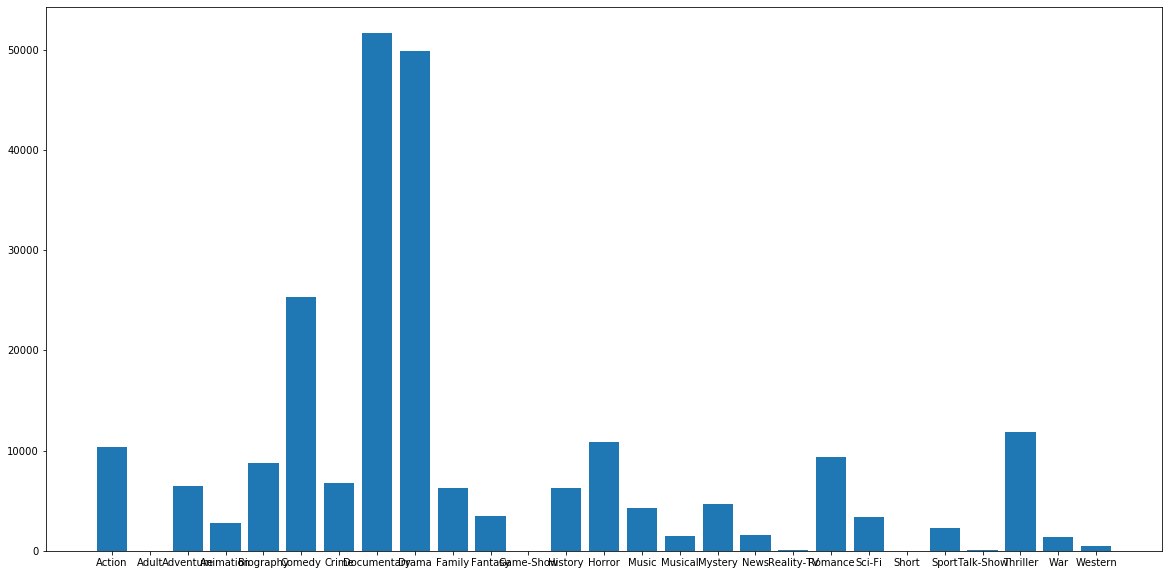

In [81]:
flat_list = [item for sublist in imdb_title_basics.genres for item in sublist]
fig, ax = plt.subplots(figsize = (20,10))
dat = np.unique(flat_list, return_counts= True)
ax.set_xlabel('Genre')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Genres in Movies')
ax.bar(x = dat[0], height = dat[1]);

#### From the imdb.title.crew file, the writers column is dropped.  The directors column will be explored.

In [44]:
imdb_title_crew = pd.read_csv('./data/imdb.title.crew.csv')
imdb_title_crew.drop(columns = 'writers', inplace = True)
imdb_title_crew = imdb_title_crew.dropna()
imdb_title_crew.directors = imdb_title_crew.directors.apply(lambda x: x.split(','))
imdb_title_crew.head()

,tconst,directors
0,tt0285252,[nm0899854]
2,tt0462036,[nm1940585]
3,tt0835418,[nm0151540]
4,tt0878654,"[nm0089502, nm2291498, nm2292011]"
5,tt0879859,[nm2416460]


#### The imdb.title.principals file has role data for movies.  The job and characters columns are almost entirely incomplete and are dropped.

In [48]:
imdb_title_principals = pd.read_csv('./data/imdb.title.principals.csv')
imdb_title_principals.drop(columns = {'job', 'characters'}, inplace = True)
imdb_title_principals.head()
imdb_title_basics.merge(imdb_title_principals, on='tconst').set_index('nconst').merge(imdb_name_basics, on='nconst')

,nconst,tconst,primary_title,runtime_minutes,genres,ordering,category,primary_name
0,nm0006210,tt0063540,Sunghursh,175.0,"[Action, Crime, Drama]",10,composer,Naushad
1,nm0474801,tt0063540,Sunghursh,175.0,"[Action, Crime, Drama]",1,actor,Dilip Kumar
2,nm0904537,tt0063540,Sunghursh,175.0,"[Action, Crime, Drama]",2,actress,Vyjayanthimala
3,nm0756379,tt0063540,Sunghursh,175.0,"[Action, Crime, Drama]",3,actor,Balraj Sahni
4,nm0474876,tt0063540,Sunghursh,175.0,"[Action, Crime, Drama]",4,actor,Sanjeev Kumar
...,...,...,...,...,...,...,...,...
1006178,nm10538632,tt9916754,Chico Albuquerque - Revelações,87.0,[Documentary],1,self,José Albano
1006179,nm3699941,tt9916754,Chico Albuquerque - Revelações,87.0,[Documentary],2,self,Luis Albuquerque
1006180,nm9813366,tt9916754,Chico Albuquerque - Revelações,87.0,[Documentary],3,self,Monica Albuquerque
1006181,nm8810966,tt9916754,Chico Albuquerque - Revelações,87.0,[Documentary],4,self,Ricardo Albuquerque


#### imdb.title.ratings has sitewide rating data.  No cleaning is needed as all entries are valid

,averagerating,numvotes
count,59996.000000,5.999600e+04
mean,6.212484,4.336017e+03
std,1.444635,3.355926e+04
min,1.000000,1.100000e+01
25%,5.400000,2.700000e+01
50%,6.400000,8.800000e+01
75%,7.200000,4.290000e+02
max,10.000000,1.841066e+06


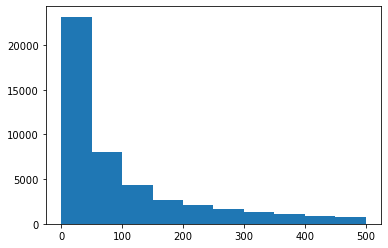

In [64]:
imdb_title_ratings = pd.read_csv('./data/imdb.title.ratings.csv')
imdb_title_ratings = imdb_title_ratings.loc[imdb_title_ratings.numvotes >10]
fig, ax = plt.subplots()
# ax.hist(imdb_title_ratings.averagerating);
ax.hist(imdb_title_ratings.numvotes, range= (0, 500));
imdb_title_ratings.describe()

In [82]:
tmdb_movies = pd.read_csv('./data/tmdb.movies.csv')
tmdb_movies

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [65]:
def clean_columns(series):
    return series.apply(lambda x: float(x.replace('$', '').replace(',', '')))

In [66]:
tn_movie_budgets = pd.read_csv('./data/tn.movie_budgets.csv')
tn_movie_budgets.production_budget = clean_columns(tn_movie_budgets.production_budget)
tn_movie_budgets.domestic_gross = clean_columns(tn_movie_budgets.domestic_gross)
tn_movie_budgets.worldwide_gross = clean_columns(tn_movie_budgets.worldwide_gross)

In [83]:
tn_movie_budgets['budget_gross_ratio'] = tn_movie_budgets.worldwide_gross / tn_movie_budgets.production_budget
tn_movie_budgets.loc[tn_movie_budgets.domestic_gross > 0].sort_values(by = 'budget_gross_ratio', ascending = False)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_ratio
5745,46,"Jun 30, 1972",Deep Throat,25000.0,45000000.0,45000000.0,1800.000000
5613,14,"Mar 21, 1980",Mad Max,200000.0,8750000.0,99750000.0,498.750000
5492,93,"Sep 25, 2009",Paranormal Activity,450000.0,107918810.0,194183034.0,431.517853
5679,80,"Jul 10, 2015",The Gallows,100000.0,22764410.0,41656474.0,416.564740
5406,7,"Jul 14, 1999",The Blair Witch Project,600000.0,140539099.0,248300000.0,413.833333
...,...,...,...,...,...,...,...
5522,23,"Dec 31, 2014",Pancakes,400000.0,0.0,0.0,0.000000
5521,22,"Nov 4, 2005",Show Me,400000.0,0.0,0.0,0.000000
5520,21,"Apr 1, 1986",My Beautiful Laundrette,400000.0,0.0,0.0,0.000000
5116,17,"Sep 8, 2015",Checkmate,1500000.0,0.0,0.0,0.000000
